In [1]:
# import hmmlearn as hmm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from sklearn.model_selection import KFold
import shap
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [2]:
# GT_PATH = "./TestBench/GT.csv"
GT_PATH = '/Users/shawn/Documents/UMSI/Boeing Project/Inter_test/data/behavior_inter_rater_Shawn.csv'
GT = pd.read_csv(GT_PATH)
GT['Timestamp'] = pd.to_timedelta(GT['Timestamp'])

In [77]:
df = pd.DataFrame()

current_directory = os.getcwd()
data_directory = os.path.join(current_directory, "..", "data", "PandasData", "Original")
files = os.listdir(data_directory)
files.sort()

for file in files:
    if file.endswith('pkl') and not file.__contains__('FAM'):
        cur_file = pd.read_pickle(os.path.join(data_directory, file))
        if file.__contains__('NSL'):
            cur_file['Condition'] = 'NSL'
        elif file.__contains__('SLD'):
            cur_file['Condition'] = 'SLD'
        else:
            assert('File name error!')
        PID = int(file[3:6])
        cur_file['PID'] = PID
        try:
            cur_file_agg = cur_file.groupby("TimestampID").mean(numeric_only=True).reset_index()
            cur_file_dropped = cur_file.drop_duplicates(subset="TimestampID", keep='first')
            raws = ["Timestamp", "AGV_name", "TimestampID", "Condition", "PID"]
            cur_file = cur_file_agg
            cur_file[raws] = cur_file_dropped[raws].values
        except:
            raise ValueError("Error in file: " + file + " when grouping by TimestampID")

        df = pd.concat([df, cur_file])

df.reset_index(drop=True, inplace=True)
df['AGV_name'] = df['AGV_name'].str[3:].astype(int)

df['Timestamp'] = pd.to_timedelta(df['Timestamp'])

In [78]:
try:
    df = df[['AGV_name', 'User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch',
       'AGV_Yaw', 'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 'Timestamp', 'PID','Condition']]
except:
    pass

In [79]:
merged = pd.merge(left=df, right=GT, on=['Timestamp', 'PID', 'AGV_name', 'Condition'], how='right')
merged.dropna(inplace=True)
merged.head()

,AGV_name,User_X,User_Y,AGV_X,AGV_Y,AGV_Pitch,AGV_Yaw,AGV_Roll,AGV_speed,GazeOrigin_X,GazeOrigin_Y,GazeDirection_X,GazeDirection_Y,GazeDirection_Z,Timestamp,PID,Condition,State
0,1,1601.017000,8449.869000,3700.000053,11565.032737,0.499435,-89.999487,0.004539,1.245621,1648.862702,8587.032544,0.082737,0.333474,-0.931982,0 days 15:42:04,3,NSL,Start
1,1,1602.389694,8449.048375,3700.013208,11440.314833,0.535606,-89.994132,0.003928,4.675977,1656.243764,8561.253722,0.448347,0.453375,-0.658736,0 days 15:42:05,3,NSL,Start
2,1,1607.178017,8438.890763,3700.049424,11132.504763,0.546250,-89.987118,0.004031,8.585062,1666.951966,8534.507644,0.307373,-0.849390,-0.084051,0 days 15:42:06,3,NSL,Start
3,1,1621.413681,8436.000819,3700.146153,10669.187528,0.611814,-89.982469,0.003975,12.931117,1679.497653,8518.762319,0.059153,-0.745056,-0.527694,0 days 15:42:07,3,NSL,Start
4,1,1639.046681,8416.217375,3700.118819,10021.805875,0.349263,-90.051092,0.025192,15.031545,1697.720333,8494.542986,0.156417,-0.712222,-0.652319,0 days 15:42:08,3,NSL,Start


In [80]:
def remove_redundant_arrived(df):
    '''
    Remove redundant Arrived state
    '''
    df = df.sort_values(by=['Timestamp'])
    total_arrived = df[df['State'] == 'Arrived'].shape[0]
    if total_arrived > 5:
        df = df.iloc[:-(total_arrived - 5)]
    return df


merged = merged.groupby(by = ['Condition', 'AGV_name', 'PID']).apply(remove_redundant_arrived).reset_index(drop=True)
merged.replace('Arrived', 'At Station', inplace=True)
merged.replace('Start', 'At Station', inplace=True)
print(f'data size: {merged.shape[0]}')

data size: 849


In [81]:
AGV_name_list = merged['AGV_name'].unique()
PID_list = merged['PID'].unique()   
selected_AGV = np.random.randint(0, len(AGV_name_list), len(AGV_name_list)//2)
selected_PID = np.random.randint(0, len(PID_list), len(PID_list)//2)

selected_AGV = [ 0,  14,   8,   8,   4,   7,   1,  13]
selected_PID = [ 0,   5,  13,   9,  10,   3,   2,   2]

valid_set = merged[(merged['AGV_name'].isin(selected_AGV)) & (merged['PID'].isin(selected_PID))].copy()
train_set = merged[~(merged['AGV_name'].isin(selected_AGV)) | ~(merged['PID'].isin(selected_PID))].copy()

print(selected_AGV)
print(selected_PID)

[0, 14, 8, 8, 4, 7, 1, 13]
[0, 5, 13, 9, 10, 3, 2, 2]


In [82]:
try: 
    valid_set.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y',
                            # 'GazeDirection_Z'
                            ], 
                            inplace=True, errors='ignore')
    
    train_set.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y', 
                            # 'GazeDirection_Z'
                            ], 
                         inplace=True, errors='ignore')
except KeyError:
    print('KeyError')
    pass

train_set.columns


Index(['User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch', 'AGV_Yaw',
       'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 'State'],
      dtype='object')

In [83]:
print(valid_set.State.unique())

['At Station' 'Approach Sidewalk' 'Wait' 'Cross' 'Approach Target Station'
 'Move Along Sidewalk']


In [84]:
# Split data into train and test

# filter out error data 
valid_set = valid_set[valid_set['State'] != 'Error']
train_set = train_set[train_set['State'] != 'Error']

num_class = train_set['State'].nunique()

print(f'num of states: {train_set["State"].nunique()}')

train_X = train_set.drop(columns=['State'])
train_y = train_set['State']
test_X = valid_set.drop(columns=['State'])
test_y = valid_set['State']

num of states: 6


## LightGBM

In [86]:
# adapt to code
X_all= train_X
y_all = train_y

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(y_all)

In [87]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass', #'objective': #regression',
    'num_class': num_class,
    # 'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.05,
   # 'feature_fraction': 0.9,
   # 'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0, #-1,
    'feature_pre_filter': False
}


X = np.array(X_all)
Y = np.array(y_all)

rmse_v = []
mae_v = []
Corr_v = []
Xdata = []
shap_values = []

startTime = datetime.now()
count = 0;
skf = KFold(n_splits=10, shuffle=True, random_state=0)


for train_index, test_index in skf.split(X,Y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    Xdata.append(X_test)

    count = count + 1
    print(count)
    d_train = lgb.Dataset(X_train, y_train, feature_name=X_all.columns.tolist())
    d_valid = lgb.Dataset(X_test, y_test, reference=d_train, feature_name=X_all.columns.tolist())

    model = lgb.train(params, d_train, 5000, valid_sets=[d_valid],
                      callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(500)]) #verbose_eval=False, early_stopping_rounds=100)
    y_pred = model.predict(X_test)
            
    # rmse_v.append(np.sqrt(mean_squared_error(y_test, y_pred)))     
    # mae_v.append(mean_absolute_error(y_test, y_pred))    
    # Corr_v.append(np.corrcoef(y_test,y_pred))

    # explainer = shap.TreeExplainer(model, X_train)
    # shap_values.append(explainer.shap_values(X_test))
    print(datetime.now()-startTime)


1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

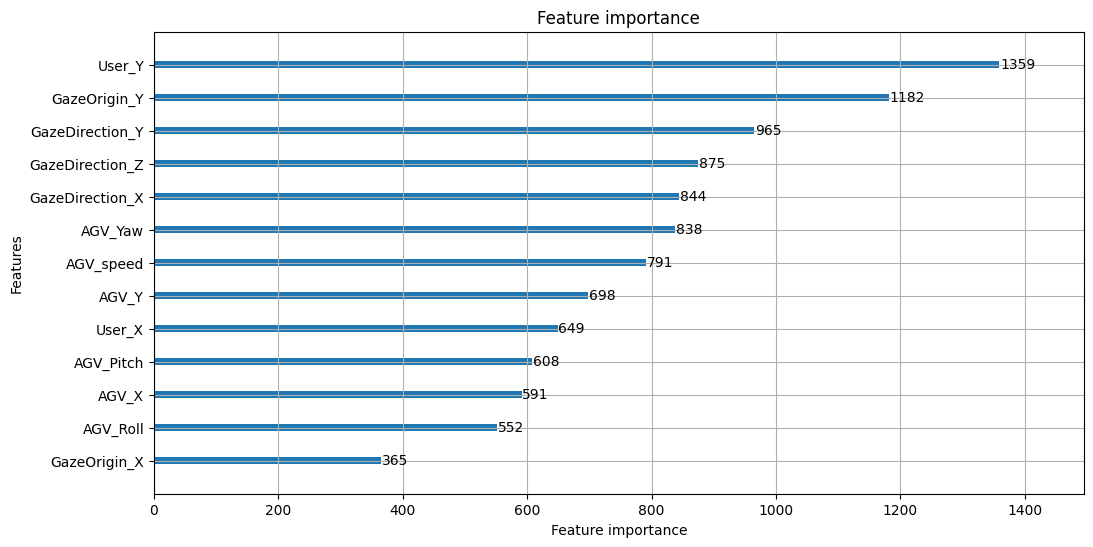

In [88]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

# Validation function

In [89]:
y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)

y_pred = label_encoder.inverse_transform(y_pred)
accuracy = accuracy_score(test_y, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.656934306569343


# Generate Test Dataframe

In [90]:
df_result = pd.DataFrame({'GT': test_y, 'Predicted': y_pred, 'Model': 'LGBM'})

## Other models

In [101]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

y_test_encoded = label_encoder.transform(test_y)

In [103]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=2000)
}

param_distributions = {
    "Logistic Regression": {
        'C': uniform(0.1, 10),
        'penalty': ['l2']
    },
    "KNN": {
        'n_neighbors': randint(1, 50),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "SVM": {
        'C': uniform(0.1, 10),
        'gamma': uniform(0.1, 1),
        'kernel': ['rbf', 'poly', 'sigmoid']
    },
    "Decision Tree": {
        'max_depth': randint(10, 100),
        'min_samples_split': uniform(0.1, 0.9),
        'min_samples_leaf': uniform(0.1, 0.5)
    },
    "Random Forest": {
        'n_estimators': randint(10, 200),
        'max_depth': randint(10, 100),
        'min_samples_split': uniform(0.1, 0.9),
        'min_samples_leaf': uniform(0.1, 0.5)
    },
    "Neural Network": {
        'hidden_layer_sizes': [(randint(10, 100).rvs(), randint(10, 100).rvs(),),
                               (randint(10, 100).rvs(),)],
        'alpha': uniform(0.0001, 0.005),
        'learning_rate_init': uniform(0.001, 0.01)
    }
}


- Best parameters for Logistic Regression: {'C': 9.60714306409916, 'penalty': 'l2'}
- Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 38, 'weights': 'distance'}

### Adding other models except LGBM to the result_df

In [104]:
for name, model in models.items():
    model.fit(train_X, train_y)
    cur_df = pd.DataFrame({'GT': test_y, 'Predicted': model.predict(test_X), 'Model': name})
    df_result = pd.concat([df_result, cur_df])

    accuracy = evaluate_model(model, train_X, train_y, test_X, test_y)
    print(f'{name} Accuracy: {accuracy}')

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Logistic Regression Accuracy: 0.24817518248175183
KNN Accuracy: 0.3284671532846715
SVM Accuracy: 0.3284671532846715
Decision Tree Accuracy: 0.6496350364963503
Random Forest Accuracy: 0.7007299270072993
Neural Network Accuracy: 0.19708029197080293


In [105]:
df_result.replace('Arrived', 'At Station', inplace=True)
df_result.replace('Start', 'At Station', inplace=True)
df_result = df_result[df_result['GT'] != 'Error']
df_result = df_result[df_result['Predicted'] != 'Error']

Ignoring `palette` because no `hue` variable has been assigned.


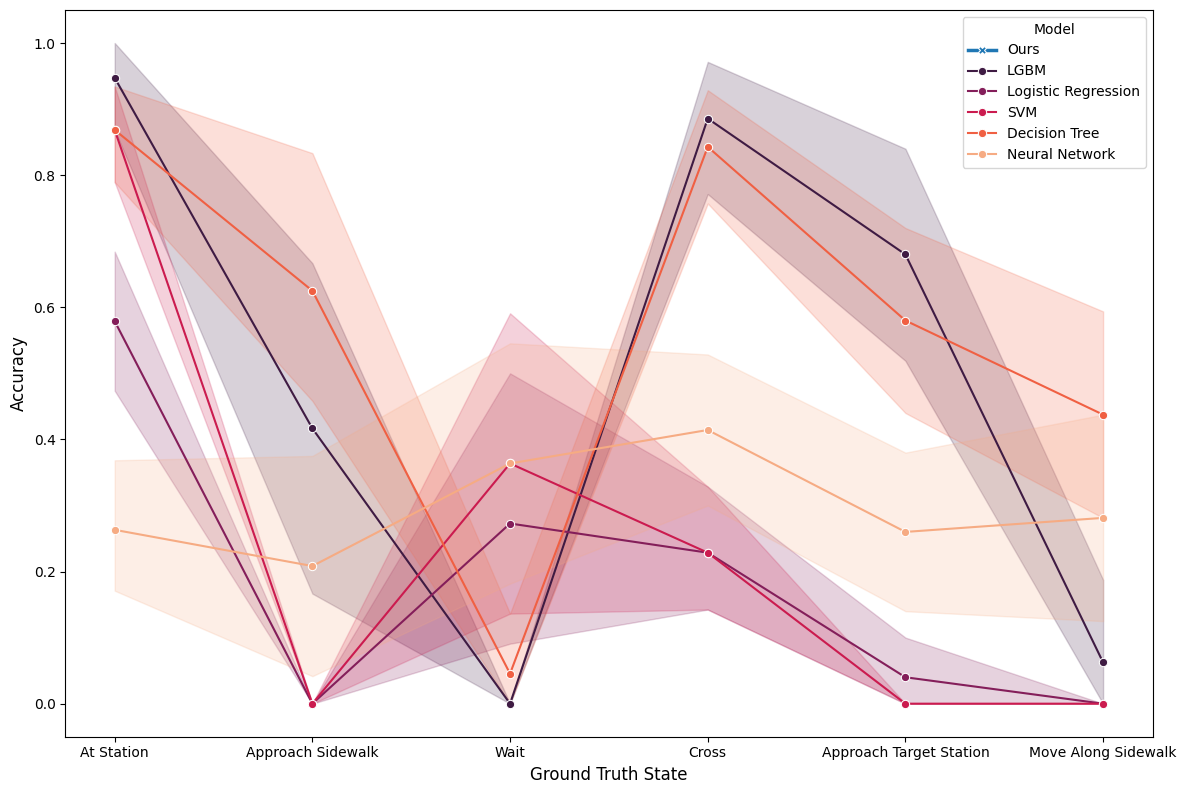

In [106]:
selected_models = ['Logistic Regression', 'SVM', 'Decision Tree', "Neural Network", 'LGBM', 'Ours']


def calculate_accuracy(row):
    return row['Predicted'] == row['GT']
# Apply the function to create a new 'Correct' column
df = df_result.copy()
df['Accuracy'] = df.apply(calculate_accuracy, axis=1)
df = df[df['Model'].isin(selected_models)]

# Plot all models with a standard line
plt.figure(figsize=(12, 8))

sns.lineplot(data=df[df['Model']=='Ours'], x='GT', y='Accuracy',marker='X', palette="rocket", linewidth=2.5, label='Ours')
sns.lineplot(data=df[df['Model']!='Ours'], x='GT', y='Accuracy', hue='Model', marker='o', palette="rocket")

plt.tight_layout()
# plt.title('Model Accuracy by States')
plt.xlabel('Ground Truth State', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
# plt.legend(title='Model')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # This removes duplicates
plt.legend(by_label.values(), by_label.keys(), title='Model')

# plt.savefig('./Figures/model_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()


# Deploy the best model

In [111]:
merged.to_pickle("../data/state_data.pkl")

In [107]:
train = merged

In [109]:
try: 
    train.drop(columns=['PID', 'Condition', 'AGV_name', 'Gaze ratio', 'TimestampID', \
                            'Timestamp', \
                            # 'facing_start_station', 'facing_end_station', 
                            # 'start_station_X', 
                            # 'start_station_Y', 'end_station_X', 'end_station_Y', 
                            # 'distance_from_start_station_X', 'distance_from_start_station_Y', 
                            # 'distance_from_end_station_X', 'distance_from_end_station_Y', \
                            # 'distance_to_closest_station', 'distance_to_closest_station_X','distance_to_closest_station_Y', 
                            # 'GazeDirection_Z'
                            ], 
                         inplace=True, errors='ignore')
except KeyError:
    print('KeyError')
    pass

train.columns

Index(['User_X', 'User_Y', 'AGV_X', 'AGV_Y', 'AGV_Pitch', 'AGV_Yaw',
       'AGV_Roll', 'AGV_speed', 'GazeOrigin_X', 'GazeOrigin_Y',
       'GazeDirection_X', 'GazeDirection_Y', 'GazeDirection_Z', 'State'],
      dtype='object')

In [110]:
train_X = train_set.drop(columns=['State'])
train_y = train_set['State']

label_encoder = LabelEncoder()
y_all = label_encoder.fit_transform(train_y)

# standardize the data
scaler = preprocessing.StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)

model = RandomForestClassifier()

model.fit(train_X, train_y)

RandomForestClassifier()